In [1]:
%matplotlib inline

import numpy as np
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as functional

torch.set_default_dtype(torch.float32)
import torch.optim as optim
import pickle
import math
# from sys import exit
import matplotlib.pyplot as plt
from sklearn import datasets

import os,sys,inspect
# currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
# parentdir = os.path.dirname(currentdir)
# sys.path.insert(0,parentdir) 

# from generative_model import realnvpfc_model

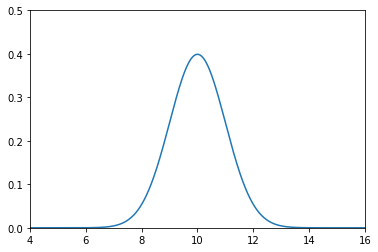

In [2]:
import filterpy.stats as stats
stats.plot_gaussian_pdf(mean=10., variance=1., 
                        xlim=(4, 16), ylim=(0, .5));

Mean of readings is 10.037


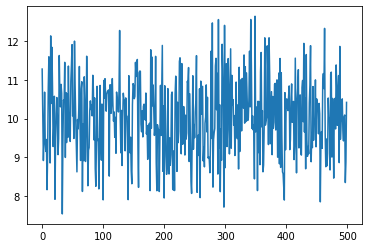

In [3]:
import numpy as np
from numpy.random import randn
import matplotlib.pyplot as plt

xs = range(500)
ys = randn(500)*1. + 10.
plt.plot(xs, ys)
print(f'Mean of readings is {np.mean(ys):.3f}')

In [4]:
from collections import namedtuple
gaussian = namedtuple('Gaussian', ['mean', 'var'])
gaussian.__repr__ = lambda s: '𝒩(μ={:.3f}, 𝜎²={:.3f})'.format(s[0], s[1])

In [5]:
g1 = gaussian(3.4, 10.1)
g2 = gaussian(mean=4.5, var=0.2**2)
print(g1)
print(g2)

𝒩(μ=3.400, 𝜎²=10.100)
𝒩(μ=4.500, 𝜎²=0.040)


In [6]:
g1.mean, g1[0], g1[1], g1.var

(3.4, 3.4, 10.1, 10.1)

In [7]:
def predict(pos, movement):
    return gaussian(pos.mean + movement.mean, pos.var + movement.var)

In [8]:
pos = gaussian(10., .2**2)
move = gaussian(15., .7**2)
predict(pos, move)

𝒩(μ=25.000, 𝜎²=0.530)

In [9]:
def update(likelihood, prior):
    posterior = likelihood * prior
    return normalize(posterior)

In [10]:
def gaussian_multiply(g1, g2):
    mean = (g1.var * g2.mean + g2.var * g1.mean) / (g1.var + g2.var)
    variance = (g1.var * g2.var) / (g1.var + g2.var)
    return gaussian(mean, variance)

def update(prior, likelihood):
    posterior = gaussian_multiply(likelihood, prior)
    return posterior

# test the update function
predicted_pos = gaussian(10., .2**2)
measured_pos = gaussian(11., .1**2)
estimated_pos = update(predicted_pos, measured_pos)
estimated_pos

𝒩(μ=10.800, 𝜎²=0.008)

In [11]:
import kf_book.kf_internal as kf_internal
from kf_book.kf_internal import DogSimulation

np.random.seed(13)

process_var = 1. # variance in the dog's movement
sensor_var = 2. # variance in the sensor

x = gaussian(0., 20.**2)  # dog's position, N(0, 20**2)
velocity = 1
dt = 1. # time step in seconds
process_model = gaussian(velocity*dt, process_var) # displacement to add to x
  
# simulate dog and get measurements
dog = DogSimulation(
    x0=x.mean, 
    velocity=process_model.mean, 
    measurement_var=sensor_var, 
    process_var=process_model.var)

# create list of measurements
zs = [dog.move_and_sense() for _ in range(10)]

In [12]:
print('PREDICT\t\t\tUPDATE')
print('     x      var\t\t  z\t    x      var')

# perform Kalman filter on measurement z
for z in zs:    
    prior = predict(x, process_model)
    likelihood = gaussian(z, sensor_var)
    x = update(prior, likelihood)

    kf_internal.print_gh(prior, x, z)

print()
print('final estimate:        {:10.3f}'.format(x.mean))
print('actual final position: {:10.3f}'.format(dog.x))

PREDICT			UPDATE
     x      var		  z	    x      var
  1.000  401.000	1.354	  1.352   1.990
  2.352    2.990	1.882	  2.070   1.198
  3.070    2.198	4.341	  3.736   1.047
  4.736    2.047	7.156	  5.960   1.012
  6.960    2.012	6.939	  6.949   1.003
  7.949    2.003	6.844	  7.396   1.001
  8.396    2.001	9.847	  9.122   1.000
 10.122    2.000	12.553	 11.338   1.000
 12.338    2.000	16.273	 14.305   1.000
 15.305    2.000	14.800	 15.053   1.000

final estimate:            15.053
actual final position:     14.838


In [13]:
from kf_book import book_plots as book_plots
from ipywidgets import interact
from ipywidgets.widgets import IntSlider

# save output in these lists for plotting
xs, predictions = [], []

process_model = gaussian(velocity, process_var) 

# perform Kalman filter
x = gaussian(0., 20.**2)
for z in zs:    
    prior = predict(x, process_model)
    likelihood = gaussian(z, sensor_var)
    x = update(prior, likelihood)

    # save results
    predictions.append(prior.mean)
    xs.append(x.mean)

def plot_filter(step):
    plt.cla()
    step -= 1
    i = step // 3 + 1
 
    book_plots.plot_predictions(predictions[:i])    
    if step % 3 == 0:
        book_plots.plot_measurements(zs[:i-1])
        book_plots.plot_filter(xs[:i-1])
    elif step % 3 == 1:
        book_plots.plot_measurements(zs[:i])
        book_plots.plot_filter(xs[:i-1])
    else:
        book_plots.plot_measurements(zs[:i])
        book_plots.plot_filter(xs[:i])

    plt.xlim(-1, 10)
    plt.ylim(0, 20)
    plt.legend(loc=2);
interact(plot_filter, step=IntSlider(value=1, min=1, max=len(predictions)*3));

interactive(children=(IntSlider(value=1, description='step', max=30, min=1), Output()), _dom_classes=('widget-…

	4.4502 2.6507 2.2871 2.1955 2.1712
	2.1647 2.1629 2.1625 2.1623 2.1623
	2.1623 2.1623 2.1623 2.1623 2.1623
	2.1623 2.1623 2.1623 2.1623 2.1623
	2.1623 2.1623 2.1623 2.1623 2.1623


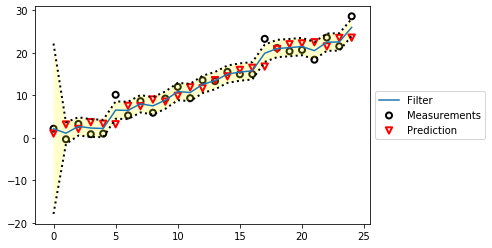

In [14]:
process_var = 2.
sensor_var = 4.5
x = gaussian(0., 400.)
process_model = gaussian(1., process_var)
N = 25

dog = DogSimulation(x.mean, process_model.mean, sensor_var, process_var)
zs = [dog.move_and_sense() for _ in range(N)]

xs, priors = np.zeros((N, 2)), np.zeros((N, 2))
for i, z in enumerate(zs):
    prior = predict(x, process_model)    
    x = update(prior, gaussian(z, sensor_var))
    priors[i] = prior
    
    xs[i] = x

book_plots.plot_measurements(zs)
book_plots.plot_filter(xs[:, 0], var=priors[:, 1])
book_plots.plot_predictions(priors[:, 0])
book_plots.show_legend()
kf_internal.print_variance(xs)

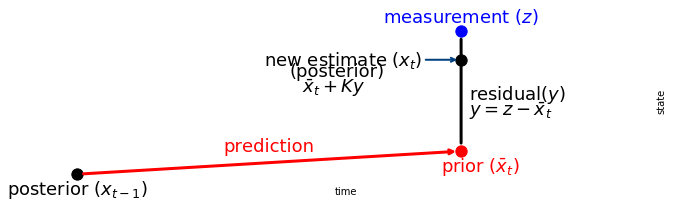

In [15]:
import kf_book.book_plots as book_plots
book_plots.show_residual_chart()

In [16]:
def update(prior, measurement):
    x, P = prior        # mean and variance of prior
    z, R = measurement  # mean and variance of measurement
    
    y = z - x        # residual
    K = P / (P + R)  # Kalman gain

    x = x + K*y      # posterior
    P = (1 - K) * P  # posterior variance
    return gaussian(x, P)

def predict(posterior, movement):
    x, P = posterior # mean and variance of posterior
    dx, Q = movement # mean and variance of movement
    x = x + dx
    P = P + Q
    return gaussian(x, P)

## Example: Multivariate Gaussian Mixture

In [17]:
from filterpy.stats import gaussian, multivariate_gaussian
# from scipy.stats import multivariate_normal

In [18]:
x = [2.5, 7.3]
mu = [2.0, 7.0]
P = [[8., 0.], 
     [0., 3.]]

%precision 4
multivariate_gaussian(x, mu, P)

0.0315

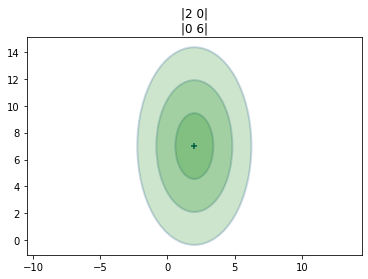

In [19]:
from filterpy.stats import plot_covariance_ellipse
P = [[2, 0], [0, 6]]
plot_covariance_ellipse((2, 7), P, fc='g', alpha=0.2, 
                        std=[1, 2, 3],
                        title='|2 0|\n|0 6|')
plt.gca().grid(b=False);

In [20]:
# Example 1 - Gaussian mixture
x1, y1, a1, sigma1 = -0.5, -0.5, 1, 0.4
x2, y2, a2, sigma2 = -0.5, 0.5, 1, 0.4
x3, y3, a3, sigma3 = 0.5, -0.5, 1, 0.4
x4, y4, a4, sigma4 = 0.5, 0.5, 1, 0.4
log_prob1 = lambda x, y: torch.log(a1 * torch.exp(-1/sigma1**2*((x-x1)**2+(y-y1)**2)) + \
                        a2 * torch.exp(-1/sigma2**2*((x-x2)**2+(y-y2)**2)) + \
                        a3 * torch.exp(-1/sigma3**2*((x-x3)**2+(y-y3)**2)) + \
                        a4 * torch.exp(-1/sigma4**2*((x-x4)**2+(y-y4)**2)))

In [21]:
loss_func = lambda x, y: -log_prob1(x, y) # select the likelihood function to estimate

Text(0.5, 1.0, 'Groud-truth distribution')

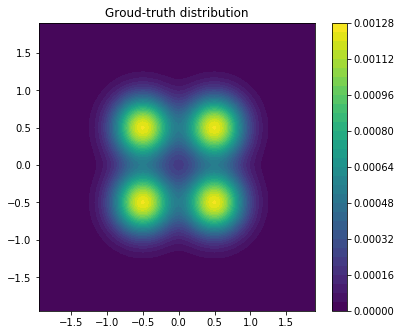

In [22]:
# plot the ground-truth distribution
x_range = np.arange(-1.95, 1.95, 0.05)
y_range = np.arange(-1.95, 1.95, 0.05)

X, Y = np.meshgrid(x_range, y_range)
value = loss_func(torch.tensor(X), torch.tensor(Y)).numpy()
Z = np.array(value)
prob_true = np.exp(-Z) / np.sum(np.exp(-Z))

fig = plt.figure(figsize=(6,5))
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height]) 
cp = plt.contourf(X, Y, prob_true, 40)
cp = plt.contour
cp = plt.colorbar()
plt.title('Groud-truth distribution')

In [23]:
# evolve = 2*np.eye(len(Z))
# Z_evolved = Z @ evolve
# prob_true = np.exp(-Z_evolved) / np.sum(np.exp(-Z_evolved))

# fig = plt.figure(figsize=(6,5))
# left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
# ax = fig.add_axes([left, bottom, width, height]) 
# cp = plt.contourf(X, Y, prob_true, 40)
# cp = plt.contour
# cp = plt.colorbar()
# plt.title('Groud-truth distribution')

In [24]:
theta = np.radians(30)

rot = lambda theta: np.array(( (np.cos(theta), -np.sin(theta)),
               (np.sin(theta),  np.cos(theta)) ))

### Implement Rotation

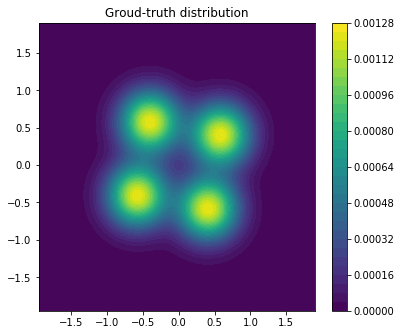

In [25]:
import skimage

prob_true_evolved = skimage.transform.rotate(prob_true, 10, resize=False)

fig = plt.figure(figsize=(6,5))
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height]) 
cp = plt.contourf(X, Y, prob_true_evolved, 40)
cp = plt.contour
cp = plt.colorbar()
plt.title('Groud-truth distribution')
plt.show()

### Animation Examples

In [26]:
prob_true

array([[4.7952e-15, 1.1684e-14, 2.7595e-14, ..., 6.3165e-14, 2.7595e-14,
        1.1684e-14],
       [1.1684e-14, 2.8471e-14, 6.7238e-14, ..., 1.5391e-13, 6.7238e-14,
        2.8471e-14],
       [2.7595e-14, 6.7238e-14, 1.5880e-13, ..., 3.6349e-13, 1.5880e-13,
        6.7238e-14],
       ...,
       [6.3165e-14, 1.5391e-13, 3.6349e-13, ..., 8.3203e-13, 3.6349e-13,
        1.5391e-13],
       [2.7595e-14, 6.7238e-14, 1.5880e-13, ..., 3.6349e-13, 1.5880e-13,
        6.7238e-14],
       [1.1684e-14, 2.8471e-14, 6.7238e-14, ..., 1.5391e-13, 6.7238e-14,
        2.8471e-14]])

In [27]:
import matplotlib.animation as animation

fig = plt.figure(figsize=(6,5))
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height]) 
cp = plt.contourf(X, Y, prob_true_evolved, 40)
cp = plt.contour
cp = plt.colorbar()
plt.title('Groud-truth distribution')
# plt.show()


# fig, ax = plt.subplots()

def f(prob_true):
    return skimage.transform.rotate(prob_true, 5, resize=False)

ims = []
for i in range(100):
    if i == 0:
        ax.imshow(prob_true)  # show an initial one first
    im = ax.imshow(prob_true, animated=True)
    ims.append([im])
    prob_true = f(prob_true)

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

# plt.show()
plt.close()

%matplotlib notebook
%matplotlib notebook

from IPython.display import HTML
HTML(ani.to_jshtml())


In [28]:
# fig, ax = plt.subplots()


# def f(x, y):
#     return np.sin(x) + np.cos(y)

# x = np.linspace(0, 2 * np.pi, 120)
# y = np.linspace(0, 2 * np.pi, 100).reshape(-1, 1)

# # ims is a list of lists, each row is a list of artists to draw in the
# # current frame; here we are just animating one artist, the image, in
# # each frame
# ims = []
# for i in range(60):
#     x += np.pi / 15.
#     y += np.pi / 20.
#     im = ax.imshow(f(x, y), animated=True)
#     if i == 0:
#         ax.imshow(f(x, y))  # show an initial one first
#     ims.append([im])

# ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
#                                 repeat_delay=1000)

# # To save the animation, use e.g.
# #
# # ani.save("movie.mp4")
# #
# # or
# #
# # writer = animation.FFMpegWriter(
# #     fps=15, metadata=dict(artist='Me'), bitrate=1800)
# # ani.save("movie.mp4", writer=writer)

# # plt.show()
# plt.close()

# %matplotlib notebook
# %matplotlib notebook

# from IPython.display import HTML
# HTML(ani.to_jshtml())


In [29]:
prob_true

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [30]:
# # Generate grid for plotting


# fig = plt.figure(figsize=(6,5))
# left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
# ax = fig.add_axes([left, bottom, width, height]) 
# # cp = plt.contourf(X, Y, prob_true_evolved, 40)
# # cp = plt.contour
# # cp = plt.colorbar()
# # plt.title('Groud-truth distribution')
# # # plt.show()

# def f(prob_true):
#     return skimage.transform.rotate(prob_true, 10, resize=False)

# # animation function
# def animate(i): 
#     prob_true = f(prob_true)
#     cont = plt.contourf(X, Y, prob_true, 40)
#     return cont  

# anim = animation.FuncAnimation(fig, animate, frames=10)

In [31]:
prob_true

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [34]:
import math
from numpy.random import randn

def compute_dog_data(z_var, process_var, count=1, dt=1.):
    "returns track, measurements 1D ndarrays"
    x, vel = 0., 1.
    z_std = math.sqrt(z_var) 
    p_std = math.sqrt(process_var)
    xs, zs = [], []
    for _ in range(count):
        v = vel + (randn() * p_std)
        x += v*dt        
        xs.append(x)
        zs.append(x + randn() * z_std)        
    return np.array(xs), np.array(zs)

<IPython.core.display.Javascript object>


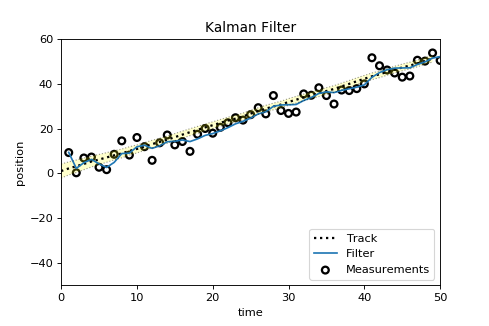

In [43]:
from filterpy.common import Q_discrete_white_noise


dt = 1.
R_var = 10
Q_var = 0.01
x = np.array([[10.0, 4.5]]).T
P = np.diag([500, 49])
F = np.array([[1, dt],
              [0,  1]])
H = np.array([[1., 0.]])
R = np.array([[R_var]])
Q = Q_discrete_white_noise(dim=2, dt=dt, var=Q_var)



from scipy.linalg import inv

count = 50
track, zs = compute_dog_data(R_var, Q_var, count)
xs, cov = [], []
for z in zs:
    # predict
    x = F @ x
    P = F @ P @ F.T + Q
    
    #update
    S = H @ P @ H.T + R
    K = P @ H.T @ inv(S)
    y = z - H @ x
    x += K @ y
    P = P - K @ H @ P
    
    xs.append(x)
    cov.append(P)

xs, cov = np.array(xs), np.array(cov)


from kf_book.mkf_internal import plot_track

plot_track(xs[:, 0], track, zs, cov, plot_P=False)



### Designing

In [47]:
from numpy.random import randn

class PosSensor(object):
    def __init__(self, pos=(0, 0), vel=(0, 0), noise_std=1.):
        self.vel = vel
        self.noise_std = noise_std
        self.pos = [pos[0], pos[1]]
        
    def read(self):
        self.pos[0] += self.vel[0]
        self.pos[1] += self.vel[1]
        
        return [self.pos[0] + randn() * self.noise_std,
                self.pos[1] + randn() * self.noise_std]

<IPython.core.display.Javascript object>


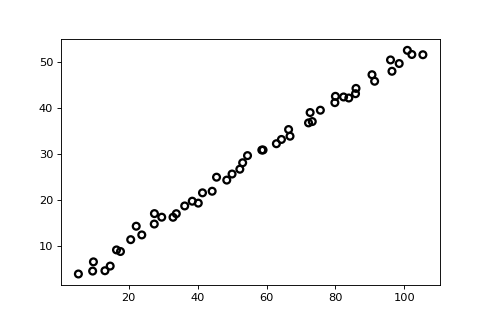

In [48]:
import matplotlib.pyplot as plt
import numpy as np
from kf_book.book_plots import plot_measurements

pos, vel = (4, 3), (2, 1)
sensor = PosSensor(pos, vel, noise_std=1)
ps = np.array([sensor.read() for _ in range(50)])
plot_measurements(ps[:, 0], ps[:, 1]);

In [49]:
from filterpy.kalman import KalmanFilter

tracker = KalmanFilter(dim_x=4, dim_z=2)
dt = 1.   # time step 1 second

tracker.F = np.array([[1, dt, 0,  0],
                      [0,  1, 0,  0],
                      [0,  0, 1, dt],
                      [0,  0, 0,  1]])

In [50]:
from scipy.linalg import block_diag
from filterpy.common import Q_discrete_white_noise

q = Q_discrete_white_noise(dim=2, dt=dt, var=0.001)
tracker.Q = block_diag(q, q)
print(tracker.Q)

[[0.0003 0.0005 0.     0.    ]
 [0.0005 0.001  0.     0.    ]
 [0.     0.     0.0003 0.0005]
 [0.     0.     0.0005 0.001 ]]


In [51]:
tracker.H = np.array([[1/0.3048, 0, 0,        0],
                      [0,        0, 1/0.3048, 0]])

In [52]:
tracker.R = np.array([[5., 0],
                      [0, 5]])
tracker.R

array([[5., 0.],
       [0., 5.]])

In [53]:
tracker.x = np.array([[0, 0, 0, 0]]).T
tracker.P = np.eye(4) * 500.

<IPython.core.display.Javascript object>


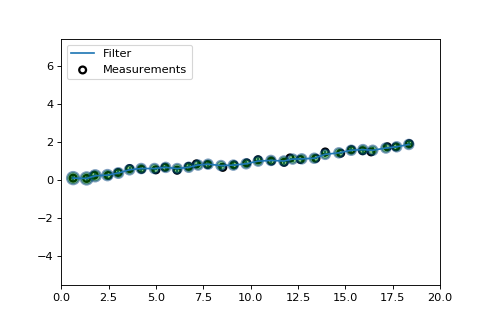

In [54]:
from filterpy.stats import plot_covariance_ellipse
from kf_book.book_plots import plot_filter

R_std = 0.35
Q_std = 0.04

def tracker1():
    tracker = KalmanFilter(dim_x=4, dim_z=2)
    dt = 1.0   # time step

    tracker.F = np.array([[1, dt, 0,  0],
                          [0,  1, 0,  0],
                          [0,  0, 1, dt],
                          [0,  0, 0,  1]])
    tracker.u = 0.
    tracker.H = np.array([[1/0.3048, 0, 0, 0],
                          [0, 0, 1/0.3048, 0]])

    tracker.R = np.eye(2) * R_std**2
    q = Q_discrete_white_noise(dim=2, dt=dt, var=Q_std**2)
    tracker.Q = block_diag(q, q)
    tracker.x = np.array([[0, 0, 0, 0]]).T
    tracker.P = np.eye(4) * 500.
    return tracker

# simulate robot movement
N = 30
sensor = PosSensor((0, 0), (2, .2), noise_std=R_std)

zs = np.array([sensor.read() for _ in range(N)])

# run filter
robot_tracker = tracker1()
mu, cov, _, _ = robot_tracker.batch_filter(zs)

for x, P in zip(mu, cov):
    # covariance of x and y
    cov = np.array([[P[0, 0], P[2, 0]], 
                    [P[0, 2], P[2, 2]]])
    mean = (x[0, 0], x[2, 0])
    plot_covariance_ellipse(mean, cov=cov, fc='g', std=3, alpha=0.5)
    
#plot results
zs *= .3048 # convert to meters
plot_filter(mu[:, 0], mu[:, 2])
plot_measurements(zs[:, 0], zs[:, 1])
plt.legend(loc=2)
plt.xlim(0, 20);


In [56]:
def FirstOrderKF(R, Q, dt):
    """ Create first order Kalman filter. 
    Specify R and Q as floats."""
    
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.zeros(2)
    kf.P *= np.array([[100, 0], [0, 1]])
    kf.R *= R
    kf.Q = Q_discrete_white_noise(2, dt, Q)
    kf.F = np.array([[1., dt],
                     [0., 1]])
    kf.H = np.array([[1., 0]])
    return kf

In [62]:
from kf_book.book_plots import plot_track

class ConstantVelocityObject(object):
    def __init__(self, x0=0, vel=1., noise_scale=0.06):
        self.x = x0
        self.vel = vel
        self.noise_scale = noise_scale

    def update(self):
        self.vel += randn() * self.noise_scale
        self.x += self.vel
        return (self.x, self.vel)
    
def sense(x, noise_scale=1.):
    return x[0] + randn()*noise_scale

In [63]:
def simulate_system(Q, count):
    obj = ConstantVelocityObject(x0=.0, vel=0.5, noise_scale=Q)
    xs, zs = [], []
    for i in range(count):
        x = obj.update()
        z = sense(x)
        xs.append(x)
        zs.append(z)
    return np.array(xs), np.array(zs)


In [64]:
from filterpy.common import Saver

def filter_data(kf, zs):
    s = Saver(kf)
    kf.batch_filter(zs, saver=s)
    s.to_array()
    return s

<IPython.core.display.Javascript object>


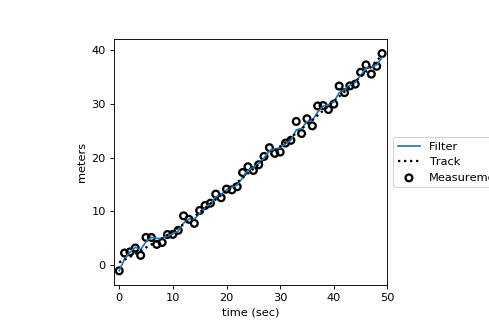

In [73]:
from kf_book.book_plots import plot_kf_output

R, Q = 1, 0.03
xs, zs = simulate_system(Q=Q, count=50)

kf = FirstOrderKF(R, Q, dt=1)
data1 = filter_data(kf, zs)

plot_kf_output(xs, data1.x, data1.z)

In [74]:
from kf_book.book_plots import plot_residual_limits, set_labels

def plot_residuals(xs, data, col, title, y_label, stds=1):
    res = xs - data.x[:, col]
    plt.plot(res)
    plot_residual_limits(data.P[:, col, col], stds)
    set_labels(title, 'time (sec)', y_label)

<IPython.core.display.Javascript object>


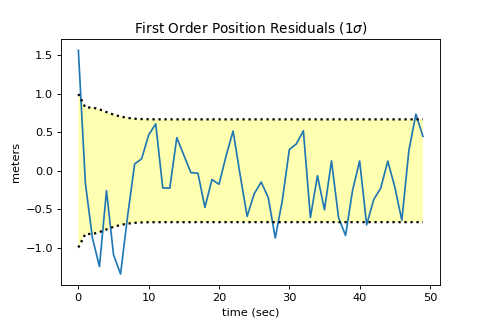

In [76]:
plot_residuals(xs[:, 0], data1, 0, 
               title='First Order Position Residuals (1$\sigma$)',
               y_label='meters')   